# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение ошибок и пропусков в данных, поиск методов их устранения.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
initial_data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
initial_data.info()
display(initial_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

- В 'ceiling_height' много пропусков. Можно будет заполнить медианными значениями после категоризации по удаленности от центра города, так как в самом центре Питера исторические здания с высокими потолками, а в Купчино-Мурино-Шушарах стандартные "муравейники" с потолками пониже. Поскольку застройка города происходила из его исторического центра, то такой подход может оказаться наиболее достоверным. Однако поскольку пропусков очень много (почти 40%), нужно будет проверить, как сильно это меняет распределение, и, возможно, не использовать эти строки вообще, когда необходимо задействовать данные из столбца.
- 22 пропуска в 'floors_total'. Можно заменить медианным значением или значением из 'floor' в случаях, когда оно больше медианного. 
- сравнительно немного пропусков в 'living_area'. Можно будет посчитать среднюю долю, которую составляет жилая площадь от общей, и заполнить пропуски, умножив это значение на 'total_area'. 
- В 'is_apartements' так много пропусков, что можно сказать, данных маловато :) Скорее всего, это просто значения False, которые забыли вставить.
- С пропусками в 'kitchen_area' поступим так же, как из с 'living_area'. Кажется, нужно будет сделать автоматизацию.
- С 'balcony' та же ситуация, что и с 'is_apartement'. Только Nan-ы нужно будет заменить не на False, а на нули.
- В 'airports_nearest' достаточно много пропусков. Можно будет посмотеть, коррелиурет ли данная величина с 'cityCenters_nearest'. Если корреляция окажется достаточной, то можно будет заполнить медианными.
- Пропуски в 'cityCenters_nearest' заполним медианными значениями с учетом группировки по 'locality_name'.
- В 'parks_around3000' пропущенные значения, скорее всего, равны нулю.
- Пропуски в 'parks_nearest' заполним значениями 3000 там, где 'parks_around3000' не равен нулю. В остальных случаях посмотрим по значение корреляции с другими столбцами и решим, что делать с пропусками.
- С пропусками в 'ponds_nearest' и 'ponds_around3000' поступим так же, как с 'parks_nearest' и 'parks_around3000'.
- Пропуски в 'days_exposition' появились, вероятнее всего, из-за того, что некоторые объявления до сих пор не сняты с публикации. Наверное, это тот случай, когда пропуски заполнять не нужно, поскольку они несут смысл. Просто будем держать в голове, чтобы они не испортили картину.
- Пропуски в 'locality_name' заполним медианными значениями после группировки по 'cityCenter_nearest'.

В целом, необходимо будет посмотреть корреляционые пары для определения наилучших способов заполнения пропусков. Для этого, также, нужно будет избавиться от типов данных 'object'.

### Исследование лучших корреляционных пар, замена типов данных, заполнение пропусков.

In [2]:
new_data = initial_data
new_data['is_apartment'] = new_data['is_apartment'].astype(bool, errors = 'ignore')
new_data['first_day_exposition'] = pd.to_datetime(new_data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S').dt.round('1d')
def only_capitals(row):
    name = []
    words = str(row).split()
    for word in words:
        if word[0].isupper() == True:
            name.append(word)
    name = ' '.join(name)
    return name
new_data['location'] = new_data['locality_name'].apply(only_capitals)
data_locations_unique = list(new_data['location'].unique())
def numeric(row):
    idx = data_locations_unique.index(row)
    return idx
new_data['location_number'] = new_data['location'].apply(numeric)
data_for_corr = new_data.drop(columns = ['locality_name', 'location'])
data_for_corr.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,location_number
total_images,1.000000,0.104473,0.115352,0.099288,-0.001987,0.010427,0.104780,0.031340,0.039860,-0.029303,...,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657,-0.045617
last_price,0.104473,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,0.000640,-0.025362,...,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146,-0.132644
total_area,0.115352,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.007836,-0.072653,...,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675,-0.097243
rooms,0.099288,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.005338,-0.147286,...,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961,-0.039681
ceiling_height,-0.001987,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,-0.030715,0.001674,...,0.087641,0.040523,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091,-0.018169
floors_total,0.010427,-0.006984,-0.075774,-0.228215,-0.028732,1.000000,-0.169311,0.678059,-0.003472,0.070151,...,0.163944,0.194065,0.108288,0.019774,-0.252833,0.097527,-0.122735,0.038864,-0.052234,-0.262005
living_area,0.104780,0.566492,0.939537,0.845977,0.090650,-0.169311,1.000000,-0.097210,-0.009535,-0.056231,...,0.428674,0.018849,-0.057912,-0.231368,0.184453,-0.050167,0.148933,-0.081674,0.142454,-0.072683
floor,0.031340,0.026576,-0.024754,-0.150862,-0.011798,0.678059,-0.097210,1.000000,-0.006182,0.036940,...,0.135531,0.168773,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463,-0.177418
is_apartment,0.039860,0.000640,-0.007836,-0.005338,-0.030715,-0.003472,-0.009535,-0.006182,1.000000,0.003569,...,-0.011218,-0.025552,0.007712,-0.000720,-0.001200,-0.018743,-0.009599,0.019909,-0.063304,0.012289
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.001674,0.070151,-0.056231,0.036940,0.003569,1.000000,...,NaN,0.031455,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476,-0.008392


- Поменяли тип 'is_apatement' на boolean, строчный был ошибкой, так как это логическая переменная.
- 'first_day_exposition' привели к формату даты и округлили до дня, так как величина характеризует день без учета времени.
- Сделали категоризацию для 'locality_name', отделив только непосредственно названия и отбросив тип местности. Далее каждой категории поставили в соответствие номер, что позволило составить корреляционную матрицу. 
- В data_for_corr перенесли все поля, кроме строчного типа, и построили корреляционную матрицу.
- Как и предполагалось, 'airports_nearest' коррелирует с 'cityCenter_nearest'. Коэффициент составил примерно 0,27 - не много, но для 'airports_nearest' это лучшая корреляционная пара, так что будем заполнять пропуски, ориентируясь на группировку по ней.
- 'ceiling_height' практически ни с чем не коррелирует - гипотеза о взаимосвязи с удаленностью от центра не подтвердилась. Если будет необходимо заполнить строки, то сделаем по общей медиане - группировка не имеет смысла.
- Гипотeза о том, что удаленность квартиры от центра города связана с местностью, подвердилась: коэффициент корреляции 'location_number' и 'cityCenter_nearest' равен примерно 0,41. Вероятно, это связано с тем, что пригороды Петербурга достаточно небольшие, и все дома в каждом из них удалены от Невского проспекта одинаково.
- У 'parks_nearest' нет "хорошей" корреляционной пары. Посмотрим, как лучше поступить дальше.

In [3]:
floor_total_median = new_data['floors_total'].sort_values().median()
dist_min = new_data['cityCenters_nearest'].min()
dist_max = new_data['cityCenters_nearest'].max()
def category_numeric(row): #функция создает назначает категорию числовому значению, разбивая весь массив на 15 категорий
    categories_number = 15
    _min = dist_min
    _max = dist_max
    size = _max - _min
    delta = size / categories_number
    for i in range(categories_number):
        if row > _min and row < (_min + delta):
            return (str(int(_min)) + ' - ' + str(int(_min + delta)))
        else:
            _min += delta
            
def super_func(row): #специальная функия для заполнения пропусков в 'floors'
    if pd.isna(row['floors_total']) and row['floor'] >= floor_total_median:
        return row['floor']
    elif pd.isna(row['floors_total']) and row['floor'] < floor_total_median:
        return floor_total_median
    else:
        return row['floors_total']

def categorial_fillna(df, column_with_nan, categorial_column, method_fill): #функция, которая обрабатывает df, заполняя NaN-ы с учетом категоризации по указанному столбцу
    categories = df[categorial_column].unique()
    column_without_nan = column_with_nan
    for category in categories:
        median = df[df[categorial_column]==category][column_with_nan].sort_values().median()
        mean = df[df[categorial_column]==category][column_with_nan].sort_values().mean()
        if method_fill == 'median':
            df.loc[df[categorial_column]==category, column_with_nan] = df[df[categorial_column]==category][column_with_nan].fillna(value = median)
        elif method_fill == 'mean':
            df.loc[df[categorial_column]==category, column_with_nan] = df[df[categorial_column]==category][column_with_nan].fillna(value = mean)
    return df

def area_fillna(df, column_with_nan, main_column, ):
    df_copy = df
    mean_share = (df_copy[column_with_nan] / df_copy[main_column]).mean()
    df_copy[column_with_nan] = df_copy[column_with_nan].fillna(value = df_copy[main_column]*mean_share)
    print(mean_share)
    return df_copy
    
    
#меняем типы переменных там, где это необходимо
new_data = initial_data
new_data['last_price'] = new_data['last_price'].astype(int)
new_data['is_apartment'] = new_data['is_apartment'].astype(bool, errors = 'ignore')
new_data['cityCenters_nearest'] = new_data['cityCenters_nearest'].astype(int, errors = 'ignore')
new_data['balcony'] = new_data['balcony'].astype(int, errors = 'ignore')


new_data['floors_total'] = new_data.apply(super_func, axis=1) #заполнение пустых значений в 'floors_total'
new_data = categorial_fillna(new_data, 'cityCenters_nearest', 'location', 'median') #заполняем пустые значений в 'cityCenters_nearest'

new_data['center_distance_group'] = new_data['cityCenters_nearest'].apply(category_numeric) #разбиваем на категории столбец 'cityCenter_groups'
new_data = categorial_fillna(new_data, 'airports_nearest', 'center_distance_group', 'median') #заполняем пропуски в 'airports_nearest'

# заполняем пропуски в 'kitchen_area' и в 'living_area'
new_data = area_fillna(new_data, 'living_area', 'total_area')
new_data = area_fillna(new_data, 'kitchen_area', 'total_area')

# заполняем пропуски в 'parks_around3000', в 'ponds_around3000' и в 'balcony'
new_data['parks_around3000'] = new_data['parks_around3000'].fillna(value = 0)
new_data['ponds_around3000'] = new_data['ponds_around3000'].fillna(value = 0)
new_data['balcony'] = new_data['balcony'].fillna(value = 0)


# изменим типы даннх
new_data = initial_data
new_data['last_price'] = new_data['last_price'].astype(int)
new_data['floors_total'] = new_data['floors_total'].astype(int, errors = 'ignore')
new_data['is_apartment'] = new_data['is_apartment'].astype(bool, errors = 'ignore')

new_data.info()

0.5647655216993234
0.1873547387717406
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
total_images             23699 non-null int64
last_price               23699 non-null int64
total_area               23699 non-null float64
first_day_exposition     23699 non-null datetime64[ns]
rooms                    23699 non-null int64
ceiling_height           14504 non-null float64
floors_total             23699 non-null int64
living_area              23699 non-null float64
floor                    23699 non-null int64
is_apartment             23699 non-null bool
studio                   23699 non-null bool
open_plan                23699 non-null bool
kitchen_area             23699 non-null float64
balcony                  23699 non-null float64
locality_name            23650 non-null object
airports_nearest         18870 non-null float64
cityCenters_nearest      18870 non-null float64
parks_around3000         23699 non-null float64
pa

- Заполнили все пропуски в 'floors_total'.
- Проблема с заполнением пропусков в 'cityCenter_nearest' и в 'airports_nearest'. При более детальном изучении выяснилось, что отсутствие значения происходит из-за того, что данные квартиры находятся в очень отдаленных населенных пунктах. Так, мы не имеем вообще никаких данных об удаленности от центра города и аэропорта по ряду отдаленных населенных пунктов (поэтому при группировке мы получаем медианное значение NaN). Можно было бы заполнить по общей медиане, но пока что оставим пропуски, чтобы не исказить картину.
- 'kitchen_area' и 'living_area' заполнили, умножив среднюю долю кухни / жилой площади от общей площади на значение 'total_area' в данном наблюдении.
- Нулями заполнили пропуски в 'ponds_around3000', в 'parks_around300' и в 'balcony'
- Всего 4 случая, когда значение parks_nearest превышают 3000 метров. Для 'ponds_nearest' таких значений вообще нет. Если мы сейчас заполним пропуски значениями 3000 или больше, то очень сильно исказим распределение, так как пободных значений крайне мало. Заполним медианным значением - появятся случаи, когда данные говорят, что в радиусе 3000 метров парков нет, но ближайший парк находится на расстоянии меньше 3000 - нелогично. Придется оставить эти пропуски и держать в уме, что в радиусе 3000 метров просто нет прудов и парков.

In [4]:
# код ревьювера
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
total_images             23699 non-null int64
last_price               23699 non-null int64
total_area               23699 non-null float64
first_day_exposition     23699 non-null datetime64[ns]
rooms                    23699 non-null int64
ceiling_height           14504 non-null float64
floors_total             23699 non-null int64
living_area              23699 non-null float64
floor                    23699 non-null int64
is_apartment             23699 non-null bool
studio                   23699 non-null bool
open_plan                23699 non-null bool
kitchen_area             23699 non-null float64
balcony                  23699 non-null float64
locality_name            23650 non-null object
airports_nearest         18870 non-null float64
cityCenters_nearest      18870 non-null float64
parks_around3000         23699 non-null float64
parks_nearest            8079 non-null f

## Там с функцией была проблема - исправил.

### Чек-лист предобработки данных
- [x] total_images           
- [x] last_price                      
- [x] total_area                  
- [x] first_day_exposition   
- [x] rooms                       
- [x] ceiling_height              
- [x] floors_total                 
- [x] living_area                
- [x] floor                           
- [x] is_apartment                   
- [x] studio                        
- [x] open_plan                     
- [x] kitchen_area          
- [x] balcony
- [x] locality_name    
- [x] airports_nearest  
- [x] cityCenters_nearest      
- [x] parks_around3000    
- [x] parks_nearest
- [x] ponds_around3000    
- [x] ponds_nearest      
- [x] days_exposition    

### Добавление расчитываемых столбцов

In [5]:
#добавление цены квадратного метра
new_data['square_meter_price'] = new_data['last_price'] / new_data['total_area']
#добавление этажа квартиры
def floor_category(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другой'
new_data['floor_category'] = new_data.apply(floor_category, axis = 1)

#добавление доли жилой площади и площади кухни от общей площади
new_data['living_share'] = new_data['living_area'] / new_data['total_area']
new_data['kitchen_share'] = new_data['kitchen_area'] / new_data['total_area']

#добавление дня недели
def number_to_name(row):
    weekday_list = pd.Series(data = ['ПН', 'ВТ', 'СР', 'ЧТ', 'ПТ', 'СБ', 'ВС'])
    return weekday_list[row]
new_data['weekday'] = pd.DatetimeIndex(new_data['first_day_exposition']).weekday
new_data['weekday'] = new_data['weekday'].apply(number_to_name)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 30 columns):
total_images             23699 non-null int64
last_price               23699 non-null int64
total_area               23699 non-null float64
first_day_exposition     23699 non-null datetime64[ns]
rooms                    23699 non-null int64
ceiling_height           14504 non-null float64
floors_total             23699 non-null int64
living_area              23699 non-null float64
floor                    23699 non-null int64
is_apartment             23699 non-null bool
studio                   23699 non-null bool
open_plan                23699 non-null bool
kitchen_area             23699 non-null float64
balcony                  23699 non-null float64
locality_name            23650 non-null object
airports_nearest         18870 non-null float64
cityCenters_nearest      18870 non-null float64
parks_around3000         23699 non-null float64
parks_nearest            8079 non-null f

### Предварительный анализ показателей, изучение характеристик распределения, дополнительная обработка данных

       total_images  last_price  total_area first_day_exposition  rooms  \
12971            19   763000000       400.0           2017-09-30      7   
19540             8   420000000       900.0           2017-12-06     12   
14706            15   401300000       401.0           2016-02-20      5   
1436             19   330000000       190.0           2018-04-04      3   
15651            20   300000000       618.0           2017-12-18      7   
22831            18   289238400       187.5           2019-03-19      2   
16461            17   245000000       285.7           2017-04-10      6   
13749             7   240000000       410.0           2017-04-01      6   
5893              3   230000000       500.0           2017-05-31      6   
8900             13   190870000       268.0           2016-03-25      3   
19865            20   180000000       347.0           2015-01-21      8   
19155            20   160000000       243.0           2018-11-12      5   
2536             16   159

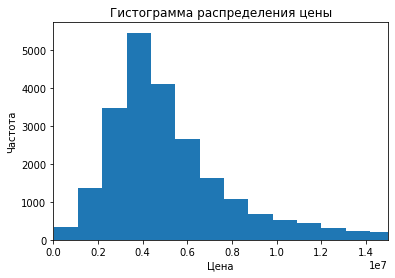

In [6]:
#анализ последней цены
new_data['last_price'].plot(kind = 'hist', bins = 700, xlim = (0, 15000000), title = 'Гистограмма распределения цены').set(xlabel = "Цена", ylabel = "Частота")
new_data['last_price'] = new_data['last_price'].replace(12190, 1219000)
print(new_data.sort_values('last_price', ascending = False).head(50))
print(new_data.sort_values('last_price', ascending = True).head(30))
print(new_data['last_price'].describe())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,location,location_number,center_distance_group,square_meter_price,floor_category,living_share,kitchen_share,weekday
19540,8,420000000,900.00,2017-12-06,12,2.80,25,409.700000,25,True,...,318.0,106.0,Санкт-Петербург,0,4566 - 8952,4.666667e+05,Последний,0.455222,0.124444,СР
12859,20,140000000,631.20,2019-04-09,7,3.90,4,322.300000,4,True,...,210.0,NaN,Санкт-Петербург,0,4566 - 8952,2.217997e+05,Последний,0.510615,0.030894,ВТ
3117,19,140000000,631.00,2019-03-30,7,NaN,5,356.367044,5,True,...,210.0,NaN,Санкт-Петербург,0,4566 - 8952,2.218700e+05,Последний,0.564766,0.095087,СБ
15651,20,300000000,618.00,2017-12-18,7,3.40,7,258.000000,5,True,...,198.0,111.0,Санкт-Петербург,0,4566 - 8952,4.854369e+05,Другой,0.417476,0.113269,ПН
5358,20,65000000,590.00,2019-02-14,15,3.50,6,409.000000,3,True,...,NaN,14.0,Санкт-Петербург,0,4566 - 8952,1.101695e+05,Другой,0.693220,0.169492,ЧТ
4237,1,50000000,517.00,2017-10-14,7,NaN,4,332.000000,3,True,...,540.0,NaN,Санкт-Петербург,0,181 - 4566,9.671180e+04,Другой,0.642166,0.042553,СБ
8018,20,84000000,507.00,2015-12-17,5,4.45,7,301.500000,7,True,...,NaN,1078.0,Санкт-Петербург,0,4566 - 8952,1.656805e+05,Последний,0.594675,0.089744,ЧТ
5893,3,230000000,500.00,2017-05-31,6,NaN,7,282.382761,7,True,...,198.0,50.0,Санкт-Петербург,0,4566 - 8952,4.600000e+05,Последний,0.564766,0.080000,СР
15016,8,150000000,500.00,2016-01-13,4,3.20,7,282.382761,7,True,...,531.0,303.0,Санкт-Петербург,0,4566 - 8952,3.000000e+05,Последний,0.564766,0.187355,СР
12401,20,91500000,495.00,2017-06-19,7,4.65,7,347.500000,7,True,...,NaN,14.0,Санкт-Петербург,0,4566 - 8952,1.848485e+05,Последний,0.702020,0.050505,ПН


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,location,location_number,center_distance_group,square_meter_price,floor_category,living_share,kitchen_share,weekday
19904,4,2400000,12.00,2017-07-19,1,2.55,5,10.000000,2,True,...,45.0,200.0,Санкт-Петербург,0,181 - 4566,200000.000000,Другой,0.833333,0.187355,СР
17961,3,1400000,13.00,2017-12-03,1,2.60,9,7.341952,1,True,...,185.0,410.0,Санкт-Петербург,0,13338 - 17724,107692.307692,Первый,0.564766,0.187355,ВС
19546,3,1850000,13.00,2019-03-11,1,3.40,5,7.341952,2,False,...,NaN,24.0,Санкт-Петербург,0,4566 - 8952,142307.692308,Другой,0.564766,0.187355,ПН
19807,0,3800000,13.00,2018-07-04,1,NaN,5,10.000000,3,True,...,27.0,9.0,Санкт-Петербург,0,181 - 4566,292307.692308,Другой,0.769231,0.187355,СР
19558,2,1686000,13.20,2018-12-17,1,NaN,5,7.454905,1,True,...,155.0,19.0,Санкт-Петербург,0,181 - 4566,127727.272727,Первый,0.564766,0.187355,ПН
19642,5,1190000,14.00,2018-07-29,1,NaN,5,11.000000,1,True,...,NaN,4.0,Санкт-Петербург,0,8952 - 13338,85000.000000,Первый,0.785714,0.142857,ВС
16949,9,1550000,15.00,2018-08-21,1,2.70,9,8.471483,1,True,...,1079.0,42.0,Санкт-Петербург,0,13338 - 17724,103333.333333,Первый,0.564766,0.187355,ВТ
12040,5,1900000,15.00,2018-06-27,1,2.50,5,8.471483,1,True,...,NaN,45.0,Сосновый Бор,51,None,126666.666667,Первый,0.564766,0.187355,СР
8886,10,2450000,15.50,2018-08-22,0,NaN,5,10.000000,2,True,...,446.0,27.0,Санкт-Петербург,0,4566 - 8952,158064.516129,Другой,0.645161,0.187355,СР
9412,5,2100000,16.00,2017-12-10,0,NaN,6,13.000000,1,True,...,72.0,3.0,Санкт-Петербург,0,181 - 4566,131250.000000,Первый,0.812500,0.187355,ВС


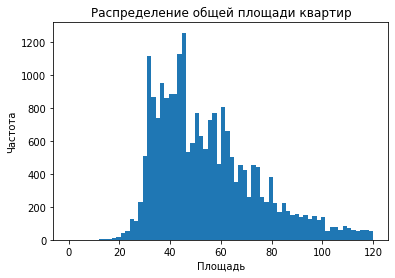

In [7]:
#анализ общей площади
new_data['total_area'].plot(kind = 'hist', bins = 70, range = (0,120), title = 'Распределение общей площади квартир').set(xlabel = "Площадь", ylabel = "Частота")
new_data['total_area'].describe()
display(new_data.sort_values(('total_area'), ascending = False).head(30))
display(new_data.sort_values(('total_area'), ascending = True).head(30))

197
197


[Text(0, 0.5, 'Частота'), Text(0.5, 0, 'Количество комнат')]

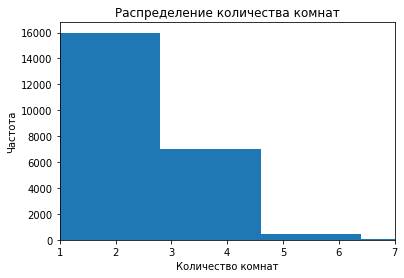

In [8]:
#анализ числа комнат
print(new_data.query('rooms == 0').count().max())
print(initial_data.query('rooms == 0').count().max()) #проверим, а сколько таких занчений было изначально
new_data = new_data.query('rooms != 0')
new_data['rooms'].plot(kind = 'hist', title = 'Распределение количества комнат', xlim = (1, 7)).set(xlabel = "Количество комнат", ylabel = "Частота")

count    14422.000000
mean         2.769607
std          1.248101
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
       total_images  last_price  total_area first_day_exposition  rooms  \
355              17     3600000        55.2           2018-07-12      2   
3148             14     2900000        75.0           2018-11-12      3   
4643              0     4300000        45.0           2018-02-01      2   
5076              0     3850000        30.5           2018-10-03      1   
5246              0     2500000        54.0           2017-10-13      2   
5669              4     4400000        50.0           2017-08-08      2   
5807             17     8150000        80.0           2019-01-09      2   
6246              6     3300000        44.4           2019-03-25      2   
9379              5     3950000        42.0           2017-03-26      3   
10773             8     3800000      

[Text(0, 0.5, 'Цена'), Text(0.5, 0, 'Высота потолков')]

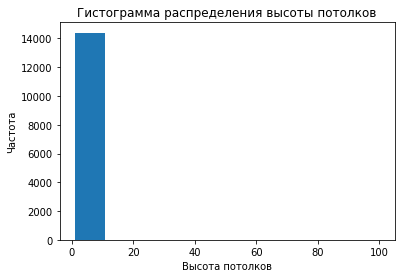

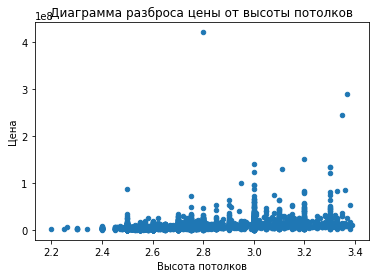

In [9]:
#анализ высоты потолков
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import legend
import os
print(new_data['ceiling_height'].describe())
new_data['ceiling_height'].plot(kind = 'hist', title = 'Гистограмма распределения высоты потолков').set(xlabel = "Высота потолков", ylabel = "Частота")
print(new_data.query('ceiling_height > 10').head(30))

new_data = new_data.query('(ceiling_height < 3.4) | ((ceiling_height > 22)&(ceiling_height < 34))')
def divide_by_ten(row):
    if row >= 22:
        return (row/10)
    else:
        return row
new_data['ceiling_height'] = new_data['ceiling_height'].apply(divide_by_ten)
new_data = new_data.query('ceiling_height >= 2.2')
new_data.plot(kind = 'scatter', x = 'ceiling_height', y = 'last_price', title = 'Диаграмма разброса цены от высоты потолков').set(xlabel = "Высота потолков", ylabel = "Цена")

## Выводы анализа
### Анализ последней цены
- Обнаружена ошибка в самой маленькой цене 12 190 рублей. Едва ли верится, что квартира в 100 квадратных метров, непосредственно в самом Санкт-Петербурге может столько стоить. Скорее всего, три нуля потерялось - исправим.
- В целом, распределение ожидаемо нормальное. Может показаться, что "хвост" справа - это выброс, так как даже в Питере квартиры не могут стоить больше 30 миллионов. Однако при детальном рассмотрении мы увидим, что это правда уникальные случаи, когда площадь может достигать несколько сотен метров. Небольшой хвост слева тоже не выброс: эти квартиры находятся в труднодоступных пригородах и невелики по площади. Вполне нормальный бюджетный вариант для людей, которые работают удаленно и любят очень тихие места, но также иногда посещают Петербург.
- Среднее значительно превосходит медиану из-за большого количества "сверхдорогих" квартир.
- Наибольшее частота наблюдений в промежутке от 3 до 5 миллионов рублей

### Анализ площади
- Распределение чуть меньше похоже на нормальное, но тоже есть "хвост справа" (все те же огромные дорогие квартиры).
- Пиковая частота значений находится на отметке в 30 квадратных метров и на на 45. Вполне реалистично и похоже на правду.
- Может показаться, что такое "неровное значение" - результат некачественной обработки данных. Однако, вероятнее всего, так происходит из-за большого количества плановых построек. Очень много "одинаковых" квартир, которые разбиваются на группы и создают эти самые "пики". 

### Анализ числа комнат
- Обнаружено 197 наблюдений со значением числа комнат 0. Они были в данных изначально, то есть это не ошибка предобработки и заполнения пропусков. Удалим их, они портят данные.
- Наибольшее количество - "однушки" и "двушки". Также, много "трешек", а дальше резкое снижение количества наблюдений от четверки. Далее - меньше тысячи наблюдений по каждому количеству комнат.

### Анализ высоты потолков
- Обнаружены аномальные значения. Высота потолков больше 3,7 выглядит подозрительной, особенно когда мы смотрим на график зависимости цены от высоты потолка. Поступим с ними так: значения от 22 до 34 поделим на 10 (скорее всего, в них пропущена запятая), а остальные удалим. Именно от 22 до 34 сравнительно много значений, что может интерпретироваться как ошибка при ручном наборе.
- Несколько значений меньше 2.2. Их очень мало - удалим для ясности картины.
- В целом, распределение очень похоже на правую половину нормального. Медиана и среднее из-за большой плотности в начале распределения смещены влево. Это объясняется тем, что существуют стандарты высоты потолков, ниже которых квартир нет или почти нет. Как можно видеть из графика, этот минимум равен примерно 2.4. Более того, <a href="http://potolki-info.ru/kvartira/standartnaya-vysota-potolkov-normy-i-praktika#ogl-2">нормы СНиП</a> устанавливают в России минимум в 2.5 метра

### Итоговый анализ данных и ответы на вопросы

count    11567.000000
mean       187.606553
std        225.396319
min          1.000000
25%         45.000000
50%        102.000000
75%        242.000000
max       1580.000000
Name: days_exposition, dtype: float64


[Text(0, 0.5, 'Количество дней публикации'), Text(0.5, 0, 'Последняя цена')]

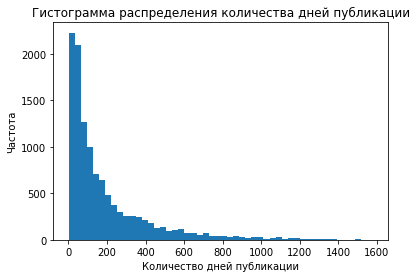

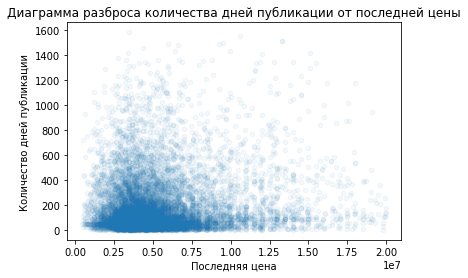

In [10]:
#new_data['days_exposition'].hist(bins = 50)
new_data['days_exposition'].plot(kind = 'hist', bins = 50, title = 'Гистограмма распределения количества дней публикации').set(xlabel = "Количество дней публикации", ylabel = "Частота")
print(new_data['days_exposition'].describe())
new_data.query('last_price < 20000000').plot(kind = 'scatter', x = 'last_price', y = 'days_exposition', alpha = 0.05, title = 'Диаграмма разброса количества дней публикации от последней цены').set(xlabel = "Последняя цена", ylabel = "Количество дней публикации")

[Text(0, 0.5, 'Цена'), Text(0.5, 0, 'Количество дней публикации')]

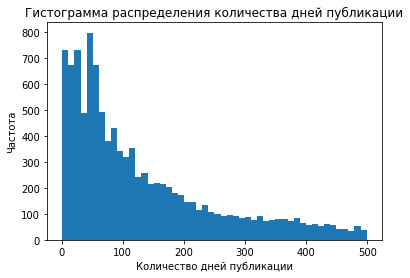

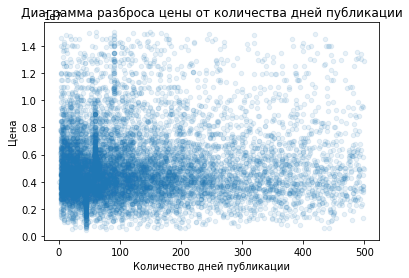

In [11]:
#посмотрим, что будет, если "обрубить хвост"
new_data = new_data.query('days_exposition < 500')
new_data['days_exposition'].plot(kind = 'hist', bins = 50, title = 'Гистограмма распределения количества дней публикации').set(xlabel = "Количество дней публикации", ylabel = "Частота")
new_data.query('last_price < 15000000').plot(kind = 'scatter', x = 'days_exposition', y = 'last_price', alpha = 0.1, title = 'Диаграмма разброса цены от количества дней публикации').set(xlabel = "Количество дней публикации", ylabel = "Цена")

#### Анализ срока продажи
- Яркий пример распределния Пуассона. Все предсказуемо, поскольку это распределение часто характеризует количество времени, потраченное, например, в очереди или на продажу квартиры.
- Значимой зависимости срока продажи от цены не обнаружена. "Темное пятно" обусловено тем, что подобные значения просто наиболее часто встречаются.
- Среднее и медиана распределения равны 187 и 102 дня соответственно. Разница обусловена высокой концентрацией значений в промежутке от 0 до 150 дней.
- Если говрить о том, какой срок продажи наиболее вероятен, то очевидным становится утверждение о "скорее очень быстро, чем очень долго". Наиболее вероятно: до 150 дней. 150 - 400 дней можно назвать "промежутком нормального срока продажи". Дольше - довольно редкие случаи.

cityCenters_nearest   -0.214827
location_number       -0.150627
ponds_nearest         -0.110867
kitchen_share         -0.070198
airports_nearest      -0.023633
living_share          -0.010827
is_apartment          -0.009612
studio                -0.009036
open_plan              0.000890
parks_nearest          0.005981
balcony                0.018919
floors_total           0.059627
days_exposition        0.069931
floor                  0.075920
total_images           0.099911
parks_around3000       0.199396
ponds_around3000       0.217040
ceiling_height         0.343976
rooms                  0.393870
kitchen_area           0.559799
living_area            0.616102
square_meter_price     0.658560
total_area             0.715463
last_price             1.000000
Name: last_price, dtype: float64
                  last_price
floor_category              
Другой          6.140628e+06
Первый          4.433867e+06
Последний       6.033507e+06
                last_price
floors_total              


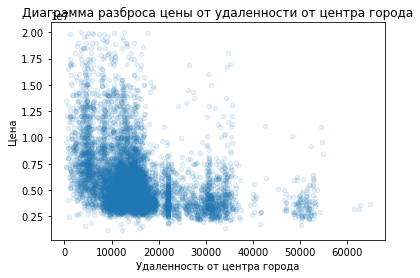

In [12]:
#посмотрим, как зависит 'last_price' от разных покаателей
print(new_data.corr()['last_price'].sort_values())
print(new_data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'floors_total', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'center_distance_group', values = 'last_price', aggfunc = 'mean').sort_values('last_price'))
print(new_data.query('last_price < 20000000').plot(title = 'Диаграмма разброса цены от удаленности от центра города', kind = 'scatter', x = 'cityCenters_nearest', y = 'last_price', alpha = 0.1).set(xlabel = "Удаленность от центра города", ylabel = "Цена"))
print(new_data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'mean'))
new_data['year'] = pd.DatetimeIndex(new_data['first_day_exposition']).year
print(new_data.pivot_table(index = 'year', values = 'last_price', aggfunc = 'mean'))
new_data['month'] = pd.DatetimeIndex(new_data['first_day_exposition']).month
print(new_data.pivot_table(index = 'month', values = 'last_price', aggfunc = 'mean'))

### От чего зависит цена?
##### Этаж
- Дешевле всех - квартиры на последнем этаже. Квартиры на первом в среднем дороже на 1,1 млн, а "другие" на 2,8 млн.
- С другой стороны, количество этажей в доме имеет значимый коэффициент корреляции с ценой (-0,56). Так, чем больше этажей, тем выше цена. Чтобы убедиться, посмотрим на сводную таблицу и увидим: выше на порядок 3,3 млн против 11,3 млн в среднем.
##### Площадь 
- "Лучшая" корреляционная пара: коэффициент равен 0,72. Так, цена более всего зависит от общей площади квартры.
- Интересное наблюдение: общая площадь много важнее доли площадей кухни и жилой площади.
##### Удаленность от центра
- Чем квартира ближе к центру, тем выше ее цена. Однако коэффиициент корреляции довольно невелик в абсолютном выражении (0,21). Проще говоря, квартиры, ближе к центру дороже, но не слишком.
- Критическая разница в цене происходит на границе в 10км, это видно из сводной таблицы. Так, будем считать, что "центр" - это в радиусе 10км.
- Невысокий коэффициент корреляции может быть обусловлен глобальным  <a href="https://www.researchgate.net/publication/344192152_Suburbanization_is_An_Irresistible_Trend">трендом сабурбанизации</a>: многие люди больше не хотят жить в центре и ищут жилье в месте "потише".
##### Количество комнат 
- Прямая зависимость видна по сводной таблице, хотя коэффициент корреляции всего 0,39 - сравнительно невысокое значение. Интересно, что квартиры с 14 комнатами значительно дешевле квартир с 12 комнатами.
##### Зависимость от дня недели, месяца, года
- Нет зависмости от дня недели. Не удивительно.
- С каждым годом квартиры дешевеют! Только с 2018 по 2019 наблюдался рост на 350 тысяч в среднем.
- Нет значимой зависимости от месяца. 

In [13]:
print(new_data.pivot_table(index = 'location', values = 'square_meter_price', aggfunc = ['count', 'mean']).sort_values([('count', 'square_meter_price')], ascending = False).head(10))
print(new_data.pivot_table(index = 'locality_name', values = 'last_price', aggfunc = 'mean').sort_values('last_price', ascending = True).head(1))
print(new_data.pivot_table(index = 'locality_name', values = 'last_price', aggfunc = 'mean').sort_values('last_price', ascending = False).head(1))

                             count               mean
                square_meter_price square_meter_price
location                                             
Санкт-Петербург               7267      110658.367933
Всеволожск                     195       65943.812253
Мурино                         189       87568.520483
Шушары                         175       78633.315001
Колпино                        169       74930.158244
Пушкин                         160      100390.163862
Кудрово                        154       94941.870861
Парголово                      115       89570.355642
Гатчина                        114       69894.158606
Петергоф                       109       82812.374851
                      last_price
locality_name                   
деревня Вахнова Кара    450000.0
               last_price
locality_name            
деревня Бор    20295200.0


### Исследование населенных пунктов
- Населенный пункт с самым дорогим квадратным метром - Санкт-Петербург.
- Самая высокая средняя стоимость жилья в деревне Вахнова Кара.
- Самая низкая стоимость жилья в деревне Бор.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 32 columns):
total_images             7267 non-null int64
last_price               7267 non-null int64
total_area               7267 non-null float64
first_day_exposition     7267 non-null datetime64[ns]
rooms                    7267 non-null int64
ceiling_height           7267 non-null float64
floors_total             7267 non-null int64
living_area              7267 non-null float64
floor                    7267 non-null int64
is_apartment             7267 non-null bool
studio                   7267 non-null bool
open_plan                7267 non-null bool
kitchen_area             7267 non-null float64
balcony                  7267 non-null float64
locality_name            7267 non-null object
airports_nearest         7267 non-null float64
cityCenters_nearest      7267 non-null float64
parks_around3000         7267 non-null float64
parks_nearest            3279 non-null float64
ponds_around3

[Text(0, 0.5, 'Цена'), Text(0.5, 0, 'Удаленность от центра города')]

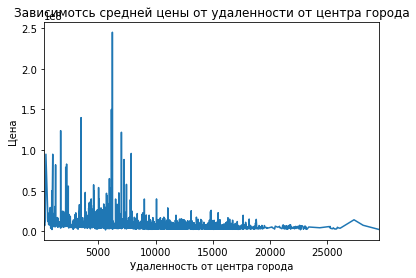

In [14]:
spb = 'Санкт-Петербург'
spb_data = new_data.query('location == @spb')
spb_data.set_axis(axis = 'index', labels = range(len(spb_data)), inplace = True)
spb_data.info()
spb_data['cityCenters_nearest'] = spb_data['cityCenters_nearest'].dropna()
spb_data['cityCenters_nearest'] = spb_data['cityCenters_nearest'].round(0).astype(int)
pivot_city_center = spb_data.pivot_table(index = 'cityCenters_nearest', values = 'last_price', aggfunc = 'mean')
pivot_city_center.sort_values('cityCenters_nearest').plot(y = 'last_price', title = 'Зависимотсь средней цены от удаленности от центра города', legend = False).set(xlabel = "Удаленность от центра города", ylabel = "Цена")

## Это что-то с питоном в юпитер хабе, у меня в локальной тетрадке все работало. Поправил, чтобы и тут все ок было :)

#### Выделение центра
Как уже было сказано ранее, "центром" Санкт-Петербурга можно назвать все в радиусе 9-10 километров от географического центра города.

In [15]:
new_data = spb_data.query('cityCenters_nearest < 10000')
print(new_data.corr()['last_price'].sort_values())
print(new_data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'floors_total', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'year', values = 'last_price', aggfunc = 'mean'))
print(new_data.pivot_table(index = 'month', values = 'last_price', aggfunc = 'mean'))

cityCenters_nearest   -0.142940
ponds_nearest         -0.123307
year                  -0.080342
kitchen_share         -0.059284
living_share          -0.049193
parks_nearest         -0.021110
studio                -0.008868
open_plan             -0.003770
is_apartment           0.003831
airports_nearest       0.004314
month                  0.010963
balcony                0.019847
floors_total           0.063534
days_exposition        0.088990
total_images           0.114428
parks_around3000       0.127466
floor                  0.128407
ponds_around3000       0.159063
ceiling_height         0.227017
rooms                  0.426062
kitchen_area           0.583451
living_area            0.635273
square_meter_price     0.689901
total_area             0.739988
last_price             1.000000
location_number             NaN
Name: last_price, dtype: float64
                  last_price
floor_category              
Другой          1.095914e+07
Первый          6.698554e+06
Последний       1.1

#### Сравнение общих выводов с выводами по центру города
Если честно, каких-либо разительных отличий, от которых можно было бы черпать полезную информацию, не было обнаружено. Очевидное отличе, которое сразу бросается в глаза, - значительное более высокие показатели стоимости.

### Общий вывод  

 1) Наибольшее влияние на цену отказывают следующие параметры:
- Общая площадь, жилая площадь и площадь кухни 
- Близость к центру
- Количество комнат и высота потолков  
  
2) Чаще всего квартиры продаются в течение двух месяцев.  

3) Самым дорогим местом, то есть центральным районом, может считаться окружность в радиусе 10 километров от Эрмитажа.  
  
4) Существует достаточно существенный кластер квартир, площадь которых достигает 900 квадратных метров.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод